In [1]:

import pandas as pd
import numpy as np 
from numpy import mean
from numpy import std
from numpy import dstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM,GRU,SimpleRNN
from keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


Using TensorFlow backend.


In [2]:
DATA_PATH = 'WISDM.txt'
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

In [3]:
def plot_activity(activity,df,start=0,stop=200):
    
    extractRowsOfActivity = (df['activity'] == activity)  # Output will be true/false.
    data = df[extractRowsOfActivity] # data has only rows that are for the requested activity.
    data = data[['x-axis','y-axis','z-axis']] # data has only the accelerometer columns.
    data = data[start:stop]
  
    ax = data.plot(subplots=True,figsize=(12,6),color=['hotpink','lightcoral','purple'],title=activity+ ', Start Row: '+str(start)+' Stop row: '+str(stop)) # Plot accelerometer for the activity.
    
    


In [4]:

df = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
df.dropna()


,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.69;
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.73;
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.69;
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.73;


In [5]:
df['z-axis'] = df['z-axis'].str.replace(';', '')
df['z-axis'] = df['z-axis'].apply(lambda x:float(x))

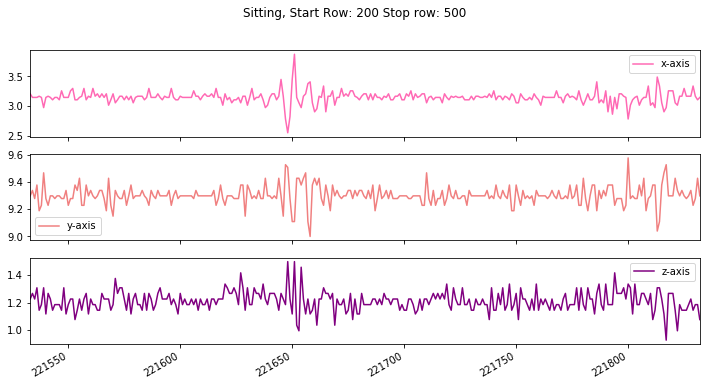

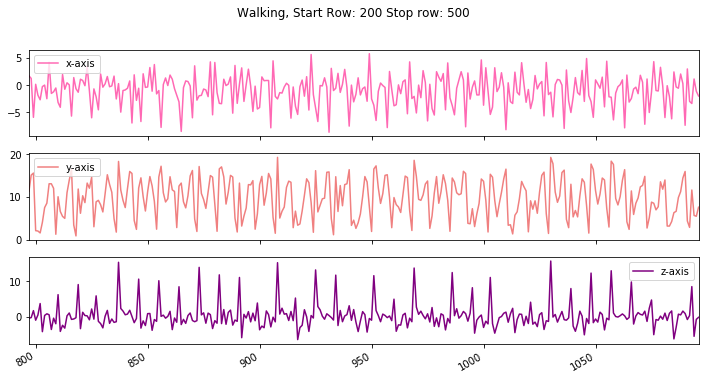

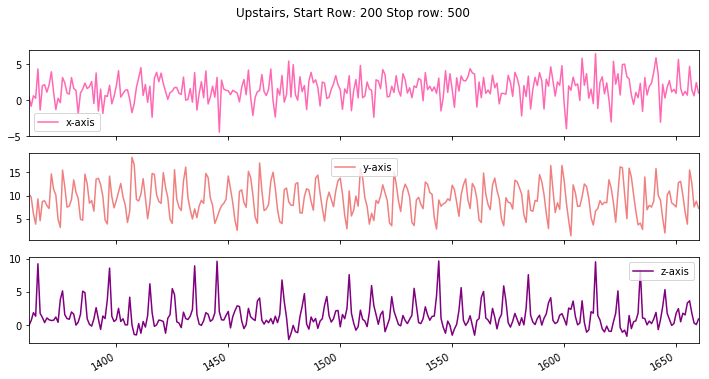

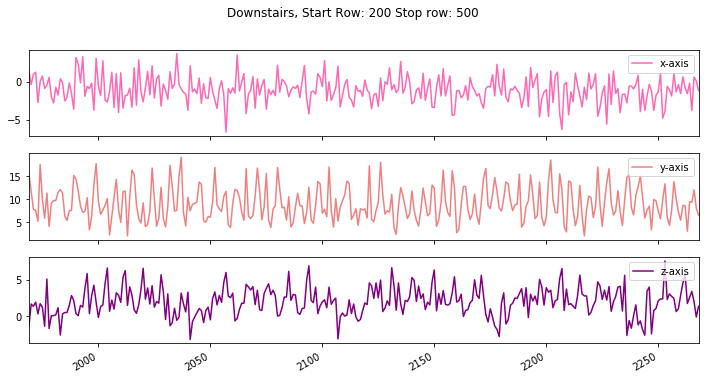

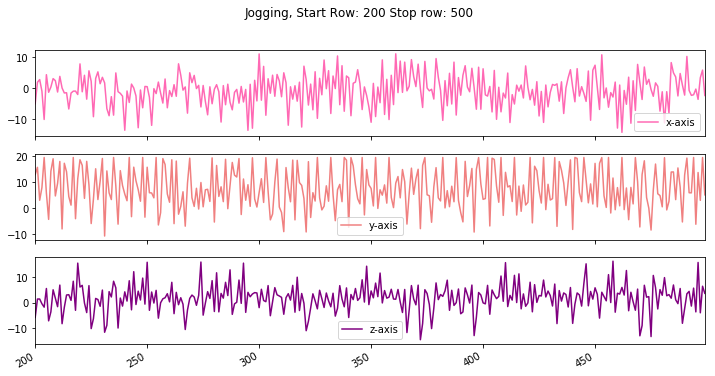

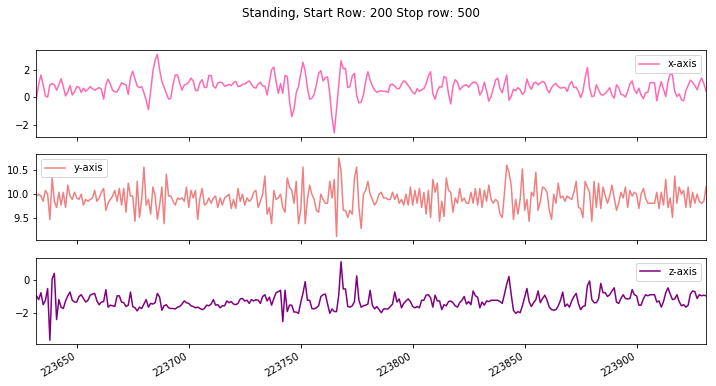

In [6]:
plot_activity('Sitting',df,200,500)
plot_activity('Walking',df,200,500)
plot_activity('Upstairs',df,200,500)
plot_activity('Downstairs',df,200,500)
plot_activity('Jogging',df,200,500)
plot_activity('Standing',df,200,500)

In [7]:
RANDOM_SEED = 13
N_TIME_STEPS = 50
N_FEATURES = 3
step = 10
segments = []
labels = []
N_CLASSES = 6
N_HIDDEN_UNITS = 64
N_EPOCHS = 20
BATCH_SIZE = 1024
LEARNING_RATE = 0.1
L2_LOSS = 0.0015


In [8]:
def readData(DATA_PATH,COLUMN_NAMES,LABELS):
    data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
    data['z-axis'].replace({';': ''}, regex=True, inplace=True)
    data['z-axis']=pd.to_numeric(data['z-axis'],errors='coerce')
    data = data.dropna() 
    return data
def plotActivity(data,activity,rowsSize,subPlotObj,subPlotTitle):
    activityX= data[data['activity'] == activity][['x-axis']][:rowsSize]
    activityY= data[data['activity'] == activity][['y-axis']][:rowsSize]
    activityZ= data[data['activity'] == activity][['z-axis']][:rowsSize]
    subPlotObj.plot(activityX, label='X')
    subPlotObj.plot(activityY,'--', label='Y')
    subPlotObj.plot(activityZ, label='Z')
    subPlotObj.set_title(subPlotTitle)
    subPlotObj.legend()
def plot_correlation(df,subPlotObj,subPlotTitle):   
   sns.heatmap(df.corr(),cmap="YlGnBu",cbar=True,ax=subPlotObj)
   tl = subPlotObj.get_xticklabels()
   subPlotObj.set_xticklabels(tl, rotation=90)
   tly = subPlotObj.get_yticklabels()
   subPlotObj.set_yticklabels(tly, rotation=0)
   subPlotObj.set_title(subPlotTitle)
def create_mixed_Df(activity1, activity2,subPlotObj):
    activity1X=projectData[projectData['activity'] == activity1]['x-axis'][:]
    activity1Y= projectData[projectData['activity'] == activity1]['y-axis'][:]
    activity1Z=projectData[projectData['activity'] == activity1]['z-axis'][:]
    activity2X=projectData[projectData['activity'] == activity2]['x-axis'][:]
    activity2Y= projectData[projectData['activity'] == activity2]['y-axis'][:]
    activity2Z=projectData[projectData['activity'] == activity2]['z-axis'][:]
    list_of_tuples = list(zip(activity1X,activity1Y,activity1Z, activity2X,activity2Y,activity2Z))      
    df = pd.DataFrame(list_of_tuples, columns = [activity1+'X', activity1+'Y',activity1+'Z',activity2+'X',activity2+'Y',activity2+'Z'])     

In [9]:
projectData=readData(DATA_PATH,COLUMN_NAMES,LABELS)

In [10]:
#create segements each segement contains 50 (N_TIME_STEPS) activity records and interval 10 (step) stepsize
labels=[]
segments=[]
for i in range(0, len(projectData) - N_TIME_STEPS, step):
    xs = projectData['x-axis'].values[i: i + N_TIME_STEPS]
    ys = projectData['y-axis'].values[i: i + N_TIME_STEPS]
    zs = projectData['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(projectData['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    
    labels.append(label)

from collections import Counter

# Sample array with 6 elements
array =labels # Replace with your actual array

# Calculate the count of each element using Counter
element_counts = Counter(array)

# Print the counts for each element
for element, count in element_counts.items():
    print(f"Element {element}: {count}")
print(len(segments),len(labels))
#reshape the segments which is (list of arrays) to one list
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

Element Jogging: 34225
Element Walking: 42433
Element Upstairs: 12274
Element Downstairs: 10056
Element Sitting: 5989
Element Standing: 4839
109816 109816


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(87852, 50, 3)
(21964, 50, 3)
(87852, 6)
(21964, 6)


# GRU

In [19]:
def display_history(history_):
    fig, ax = plt.subplots(1,2, figsize=(12, 3))
    ax[0].plot(history_.history['loss'], color='b', label="training_loss")
    ax[0].plot(history_.history['val_loss'], color='r', label="validation_loss",axes =ax[0])
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    legend = ax[0].legend(loc='best', shadow=True)
    ax[1].plot(history_.history['accuracy'], color='b', label="training_accuracy")
    ax[1].plot(history_.history['val_accuracy'], color='r',label="validation_accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def plot_metrices(model_):
    # Predicting the test data
    pred = model_.predict(X_test, batch_size=BATCH_SIZE)
    pred_class_indices = np.argmax(pred, axis=1)  # Convert predictions to class indices
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test.argmax(axis=1), pred_class_indices)
    
    # Define classes for plotting
    classes = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
    
    # Plot the confusion matrix
    plt.figure()
    ax = plt.subplot()
    ax.set_title('Confusion Matrix')
    
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Reds')
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    print(classification_report(y_test.argmax(axis=1), pred_class_indices, target_names=classes))

    # Calculate total samples
    total = cm.sum()
    
    accuracy = np.trace(cm) / total  # Total correct predictions divided by total samples
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # True positive rate for the first class
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])  # True negative rate for the second class

    print(f"ACC: {accuracy:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")


In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense

from tensorflow.keras.layers import Dense

epochs, batch_size = 30, 1024

model = Sequential()

model.add(GRU(100, input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(Dropout(0.3))

model.add(Dense(100, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model


In [31]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100)               31500     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 606       
Total params: 42,206
Trainable params: 42,206
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.25,batch_size=batch_size,verbose=1)

Train on 65889 samples, validate on 21963 samples
Epoch 1/30
65889/65889 [==============================] - 2s 34us/sample - loss: 1.1830 - accuracy: 0.5330 - val_loss: 0.6459 - val_accuracy: 0.7806
Epoch 2/30
65889/65889 [==============================] - 1s 11us/sample - loss: 0.5466 - accuracy: 0.8065 - val_loss: 0.4787 - val_accuracy: 0.8267
Epoch 3/30
65889/65889 [==============================] - 1s 12us/sample - loss: 0.4699 - accuracy: 0.8303 - val_loss: 0.4336 - val_accuracy: 0.8425
Epoch 4/30
65889/65889 [==============================] - 1s 12us/sample - loss: 0.4333 - accuracy: 0.8430 - val_loss: 0.4018 - val_accuracy: 0.8573
Epoch 5/30
65889/65889 [==============================] - 1s 11us/sample - loss: 0.3971 - accuracy: 0.8560 - val_loss: 0.3760 - val_accuracy: 0.8688
Epoch 6/30
65889/65889 [==============================] - 1s 11us/sample - loss: 0.3661 - accuracy: 0.8694 - val_loss: 0.3389 - val_accuracy: 0.8791
Epoch 7/30
65889/65889 [==============================] 

In [36]:
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
accuracy

21964/21964 [==============================] - 0s 9us/step


0.9491440653800964

In [37]:
from keras.models import load_model
model.save('harmodel.h5')  # creates a HDF5 file 'my_model.h5'

with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

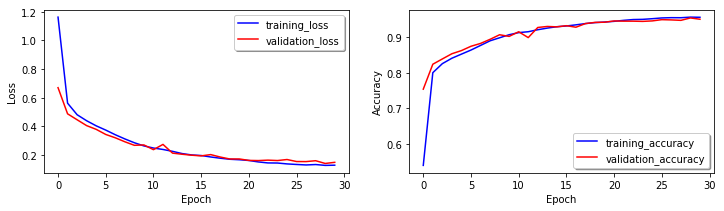

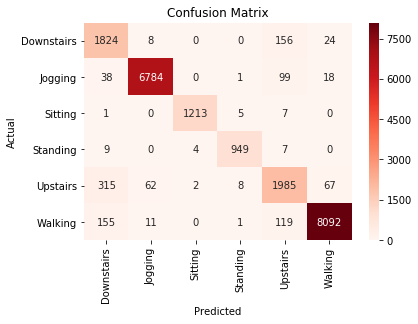

              precision    recall  f1-score   support

  Downstairs       0.78      0.91      0.84      2012
     Jogging       0.99      0.98      0.98      6940
     Sitting       1.00      0.99      0.99      1226
    Standing       0.98      0.98      0.98       969
    Upstairs       0.84      0.81      0.83      2439
     Walking       0.99      0.97      0.98      8378

    accuracy                           0.95     21964
   macro avg       0.93      0.94      0.93     21964
weighted avg       0.95      0.95      0.95     21964

ACC: 0.9491
Sensitivity: 0.9956
Specificity: 0.9944


In [40]:
display_history(history)
plot_metrices(model)

131784


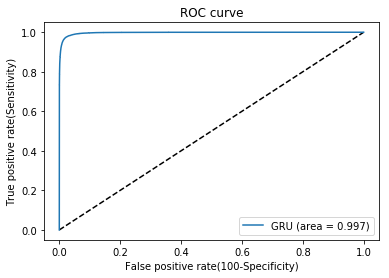

In [41]:
import sklearn.metrics
def plot_roc(model_, name):
    plt.figure()
    ax = plt.subplot()
    ax.set_title('ROC Curve')
    pred = model_.predict(X_test).ravel()
    print(pred.size)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test.ravel(), pred)
    ac = sklearn.metrics.auc(fpr, tpr)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='{} (area = {:.3f})'.format(name, ac))
    plt.xlabel('False positive rate(100-Specificity)')
    plt.ylabel('True positive rate(Sensitivity)')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show
plot_roc(model,"GRU")

In [43]:
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
y_pred = model.predict(X_test)
matrix = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))

# **LSTM**

In [45]:
epochs, batch_size =  30, 1024
model2 = Sequential()
model2.add(LSTM(100, input_shape=(X_train.shape[1],X_train.shape[2])))
model2.add(Dropout(0.3))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(y_train.shape[1], activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 606       
Total params: 52,306
Trainable params: 52,306
Non-trainable params: 0
_________________________________________________________________


In [47]:
history2 = model2.fit(X_train, y_train, epochs=epochs, validation_split=0.25,batch_size=batch_size,verbose=1)

Train on 65889 samples, validate on 21963 samples
Epoch 1/30
65889/65889 [==============================] - 3s 49us/step - loss: 0.9750 - accuracy: 0.6529 - val_loss: 0.5490 - val_accuracy: 0.8091
Epoch 2/30
65889/65889 [==============================] - 3s 41us/step - loss: 0.5204 - accuracy: 0.8175 - val_loss: 0.4661 - val_accuracy: 0.8339
Epoch 3/30
65889/65889 [==============================] - 3s 41us/step - loss: 0.4617 - accuracy: 0.8360 - val_loss: 0.4320 - val_accuracy: 0.8409
Epoch 4/30
65889/65889 [==============================] - 3s 42us/step - loss: 0.4180 - accuracy: 0.8484 - val_loss: 0.3991 - val_accuracy: 0.8502
Epoch 5/30
65889/65889 [==============================] - 3s 43us/step - loss: 0.3832 - accuracy: 0.8588 - val_loss: 0.3390 - val_accuracy: 0.8742
Epoch 6/30
65889/65889 [==============================] - 3s 42us/step - loss: 0.3462 - accuracy: 0.8728 - val_loss: 0.3106 - val_accuracy: 0.8848
Epoch 7/30
65889/65889 [==============================] - 3s 40us/st

In [48]:
_, accuracy = model2.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
accuracy

21964/21964 [==============================] - 0s 9us/step


0.9512839317321777

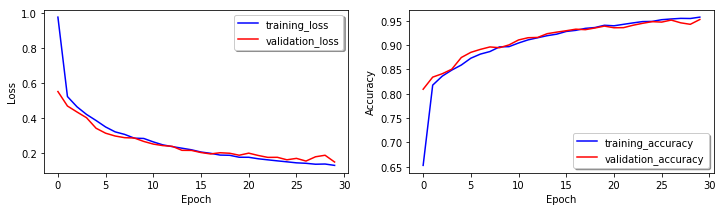

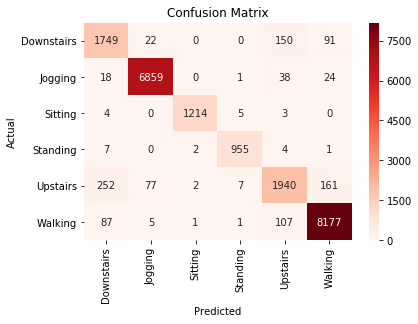

              precision    recall  f1-score   support

  Downstairs       0.83      0.87      0.85      2012
     Jogging       0.99      0.99      0.99      6940
     Sitting       1.00      0.99      0.99      1226
    Standing       0.99      0.99      0.99       969
    Upstairs       0.87      0.80      0.83      2439
     Walking       0.97      0.98      0.97      8378

    accuracy                           0.95     21964
   macro avg       0.94      0.93      0.94     21964
weighted avg       0.95      0.95      0.95     21964

ACC: 0.9513
Sensitivity: 0.9876
Specificity: 0.9974


In [49]:
display_history(history2)
plot_metrices(model2)

131784


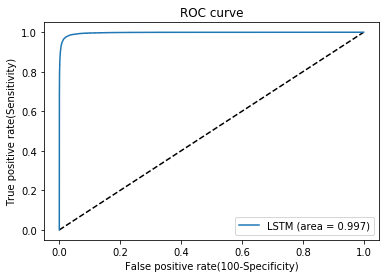

In [50]:
import sklearn.metrics
def plot_roc(model_, name):
    plt.figure()
    ax = plt.subplot()
    ax.set_title('ROC Curve')
    pred = model_.predict(X_test).ravel()
    print(pred.size)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test.ravel(), pred)
    ac = sklearn.metrics.auc(fpr, tpr)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='{} (area = {:.3f})'.format(name, ac))
    plt.xlabel('False positive rate(100-Specificity)')
    plt.ylabel('True positive rate(Sensitivity)')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show
plot_roc(model2,"LSTM")

# Simple RNN

In [51]:
epochs, batch_size =  30, 1024
model3 = Sequential()
model3.add(SimpleRNN(100, input_shape=(X_train.shape[1],X_train.shape[2])))
model3.add(Dropout(0.3))
model3.add(Dense(100, activation='relu'))
model3.add(Dense(y_train.shape[1], activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 100)               10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 606       
Total params: 21,106
Trainable params: 21,106
Non-trainable params: 0
_________________________________________________________________


In [53]:
history3 = model3.fit(X_train, y_train, epochs=epochs, validation_split=0.25,batch_size=batch_size,verbose=1)

Train on 65889 samples, validate on 21963 samples
Epoch 1/30
65889/65889 [==============================] - 2s 27us/step - loss: 1.2255 - accuracy: 0.5262 - val_loss: 0.8439 - val_accuracy: 0.7066
Epoch 2/30
65889/65889 [==============================] - 1s 22us/step - loss: 0.7636 - accuracy: 0.7349 - val_loss: 0.5888 - val_accuracy: 0.7964
Epoch 3/30
65889/65889 [==============================] - 1s 22us/step - loss: 0.5531 - accuracy: 0.8091 - val_loss: 0.4615 - val_accuracy: 0.8346
Epoch 4/30
65889/65889 [==============================] - 1s 22us/step - loss: 0.4699 - accuracy: 0.8364 - val_loss: 0.4098 - val_accuracy: 0.8527
Epoch 5/30
65889/65889 [==============================] - 1s 22us/step - loss: 0.4339 - accuracy: 0.8494 - val_loss: 0.4038 - val_accuracy: 0.8574
Epoch 6/30
65889/65889 [==============================] - 1s 22us/step - loss: 0.4123 - accuracy: 0.8563 - val_loss: 0.3748 - val_accuracy: 0.8658
Epoch 7/30
65889/65889 [==============================] - 1s 21us/st

In [54]:
_, accuracy = model3.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
accuracy

21964/21964 [==============================] - 0s 5us/step


0.9046621918678284

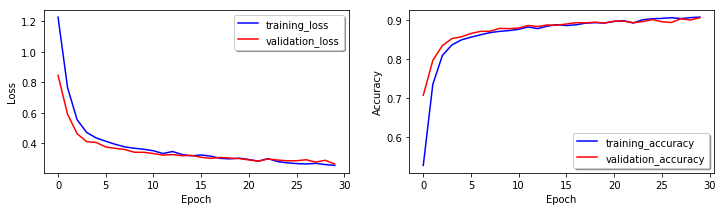

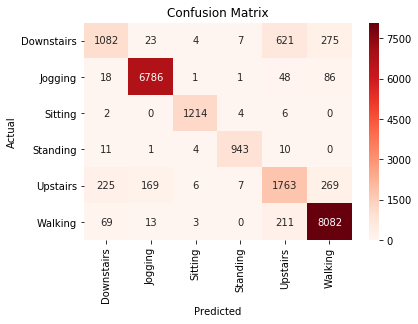

              precision    recall  f1-score   support

  Downstairs       0.77      0.54      0.63      2012
     Jogging       0.97      0.98      0.97      6940
     Sitting       0.99      0.99      0.99      1226
    Standing       0.98      0.97      0.98       969
    Upstairs       0.66      0.72      0.69      2439
     Walking       0.93      0.96      0.95      8378

    accuracy                           0.90     21964
   macro avg       0.88      0.86      0.87     21964
weighted avg       0.90      0.90      0.90     21964

ACC: 0.9047
Sensitivity: 0.9792
Specificity: 0.9974


In [55]:
display_history(history3)
plot_metrices(model3)

131784


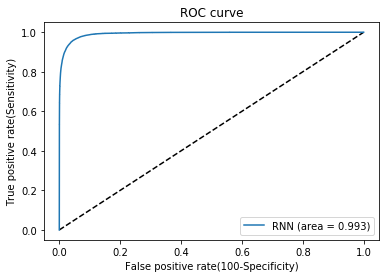

In [56]:
import sklearn.metrics
def plot_roc(model_, name):
    plt.figure()
    ax = plt.subplot()
    ax.set_title('ROC Curve')
    pred = model_.predict(X_test).ravel()
    print(pred.size)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test.ravel(), pred)
    ac = sklearn.metrics.auc(fpr, tpr)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='{} (area = {:.3f})'.format(name, ac))
    plt.xlabel('False positive rate(100-Specificity)')
    plt.ylabel('True positive rate(Sensitivity)')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show
plot_roc(model3,"RNN")

# Wisnet


In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Multiply, Add, Activation, MaxPooling1D, Concatenate, Input

# Convolved Normalized Pooled (CNPM) Block
def cnpm_block(inputs, filters, kernel_size=5, pool_size=2):
    x = Conv1D(filters, kernel_size, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    # x = MaxPooling1D(pool_size)(x)
    return x

# Identity Block
def identity_block(inputs, filters, kernel_size):
    x = Conv1D(filters, kernel_size, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

# Basic Block
def basic_block(inputs, filters, kernel_size):
    x = Conv1D(filters, kernel_size, padding='same')(inputs)
    x = BatchNormalization()(x)
    # x = ReLU()(x)
    return x

# Identity and Basic (IDBN) Block
def identity_basic_block(inputs, filters, kernel_sizes=[3, 5, 7]):
    idb_outputs = []

    for kernel_size in kernel_sizes:
        id_output = identity_block(inputs, filters, kernel_size)
        id_output = identity_block(id_output, filters, kernel_size)
        basic_output = basic_block(id_output, filters, kernel_size)
        combined_output = Add()([inputs, basic_output])
        combined_output = ReLU()(combined_output)
        idb_outputs.append(combined_output)

    if len(idb_outputs) > 1:
        idb_combined = Add()(idb_outputs)
    else:
        idb_combined = idb_outputs[0]
    
    return idb_combined

# Channel Attention Block
def channel_attention(inputs, reduction_ratio=16):
    channel = inputs.shape[-1]
    
    # Global Average Pooling
    channel_avg_pool = GlobalAveragePooling1D()(inputs)
    channel_max_pool = GlobalMaxPooling1D()(inputs)

    shared_dense_1 = Dense(channel // reduction_ratio, activation='relu')
    shared_dense_2 = Dense(channel, activation='sigmoid')

    avg_out = shared_dense_2(shared_dense_1(channel_avg_pool))
    max_out = shared_dense_2(shared_dense_1(channel_max_pool))

    # Combine the outputs of average and max pooling
    combined_out = Add()([avg_out, max_out])
    combined_out = tf.expand_dims(combined_out, axis=1)

    # Apply the attention weights to the input features
    channel_attention_output = Multiply()([inputs, combined_out])
    return channel_attention_output

# Spatial Attention Block
def spatial_attention(inputs):
    avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)

    concat = tf.concat([avg_pool, max_pool], axis=-1)
    spatial_attention = Conv1D(1, 7, padding='same', activation='sigmoid')(concat)

    # Apply the attention weights to the input features
    spatial_attention_output = Multiply()([inputs, spatial_attention])
    return spatial_attention_output

# Channel and Spatial Attention (CASb) Block
def channel_spatial_attention_block(inputs, reduction_ratio=16):
    x = channel_attention(inputs, reduction_ratio)
    x = spatial_attention(x)
    return x

# WISNet Block
def wisnet_block(inputs, filters, kernel_sizes=[3, 5, 7], reduction_ratio=16):
    x = identity_basic_block(inputs, filters, kernel_sizes)
    x = channel_spatial_attention_block(x, reduction_ratio)
    return x

# Building the WISNet Model
def build_wisnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # CNPM Block
    y = cnpm_block(inputs, 64, kernel_size=5)

    # IDBN1 Block
    x = identity_basic_block(y, 64, kernel_sizes=[3, 5, 7])

    # CASb Block
    x = channel_spatial_attention_block(x, reduction_ratio=16)
    x = Add()([x, y])

    # IDBN2 Block
    x = identity_basic_block(x, 64, kernel_sizes=[3, 5, 7])

    # CASb Block
#     x = channel_spatial_attention_block(x, reduction_ratio=16)

    # Global Pooling and Output Layer
    x = GlobalAveragePooling1D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, x)
    return model

# Define model parameters
input_shape = (X_train.shape[1],X_train.shape[2]) # Assuming 1D signal with length 50 and 64 channels
num_classes = 6        # Adjust based on the classification task

# Build and summarize the model
model4 = build_wisnet(input_shape, num_classes)
model4.summary()
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 50, 3)]      0                                            
__________________________________________________________________________________________________
conv1d_76 (Conv1D)              (None, 50, 64)       1024        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, 50, 64)       256         conv1d_76[0][0]                  
__________________________________________________________________________________________________
re_lu_69 (ReLU)                 (None, 50, 64)       0           batch_normalization_70[0][0]     
____________________________________________________________________________________________

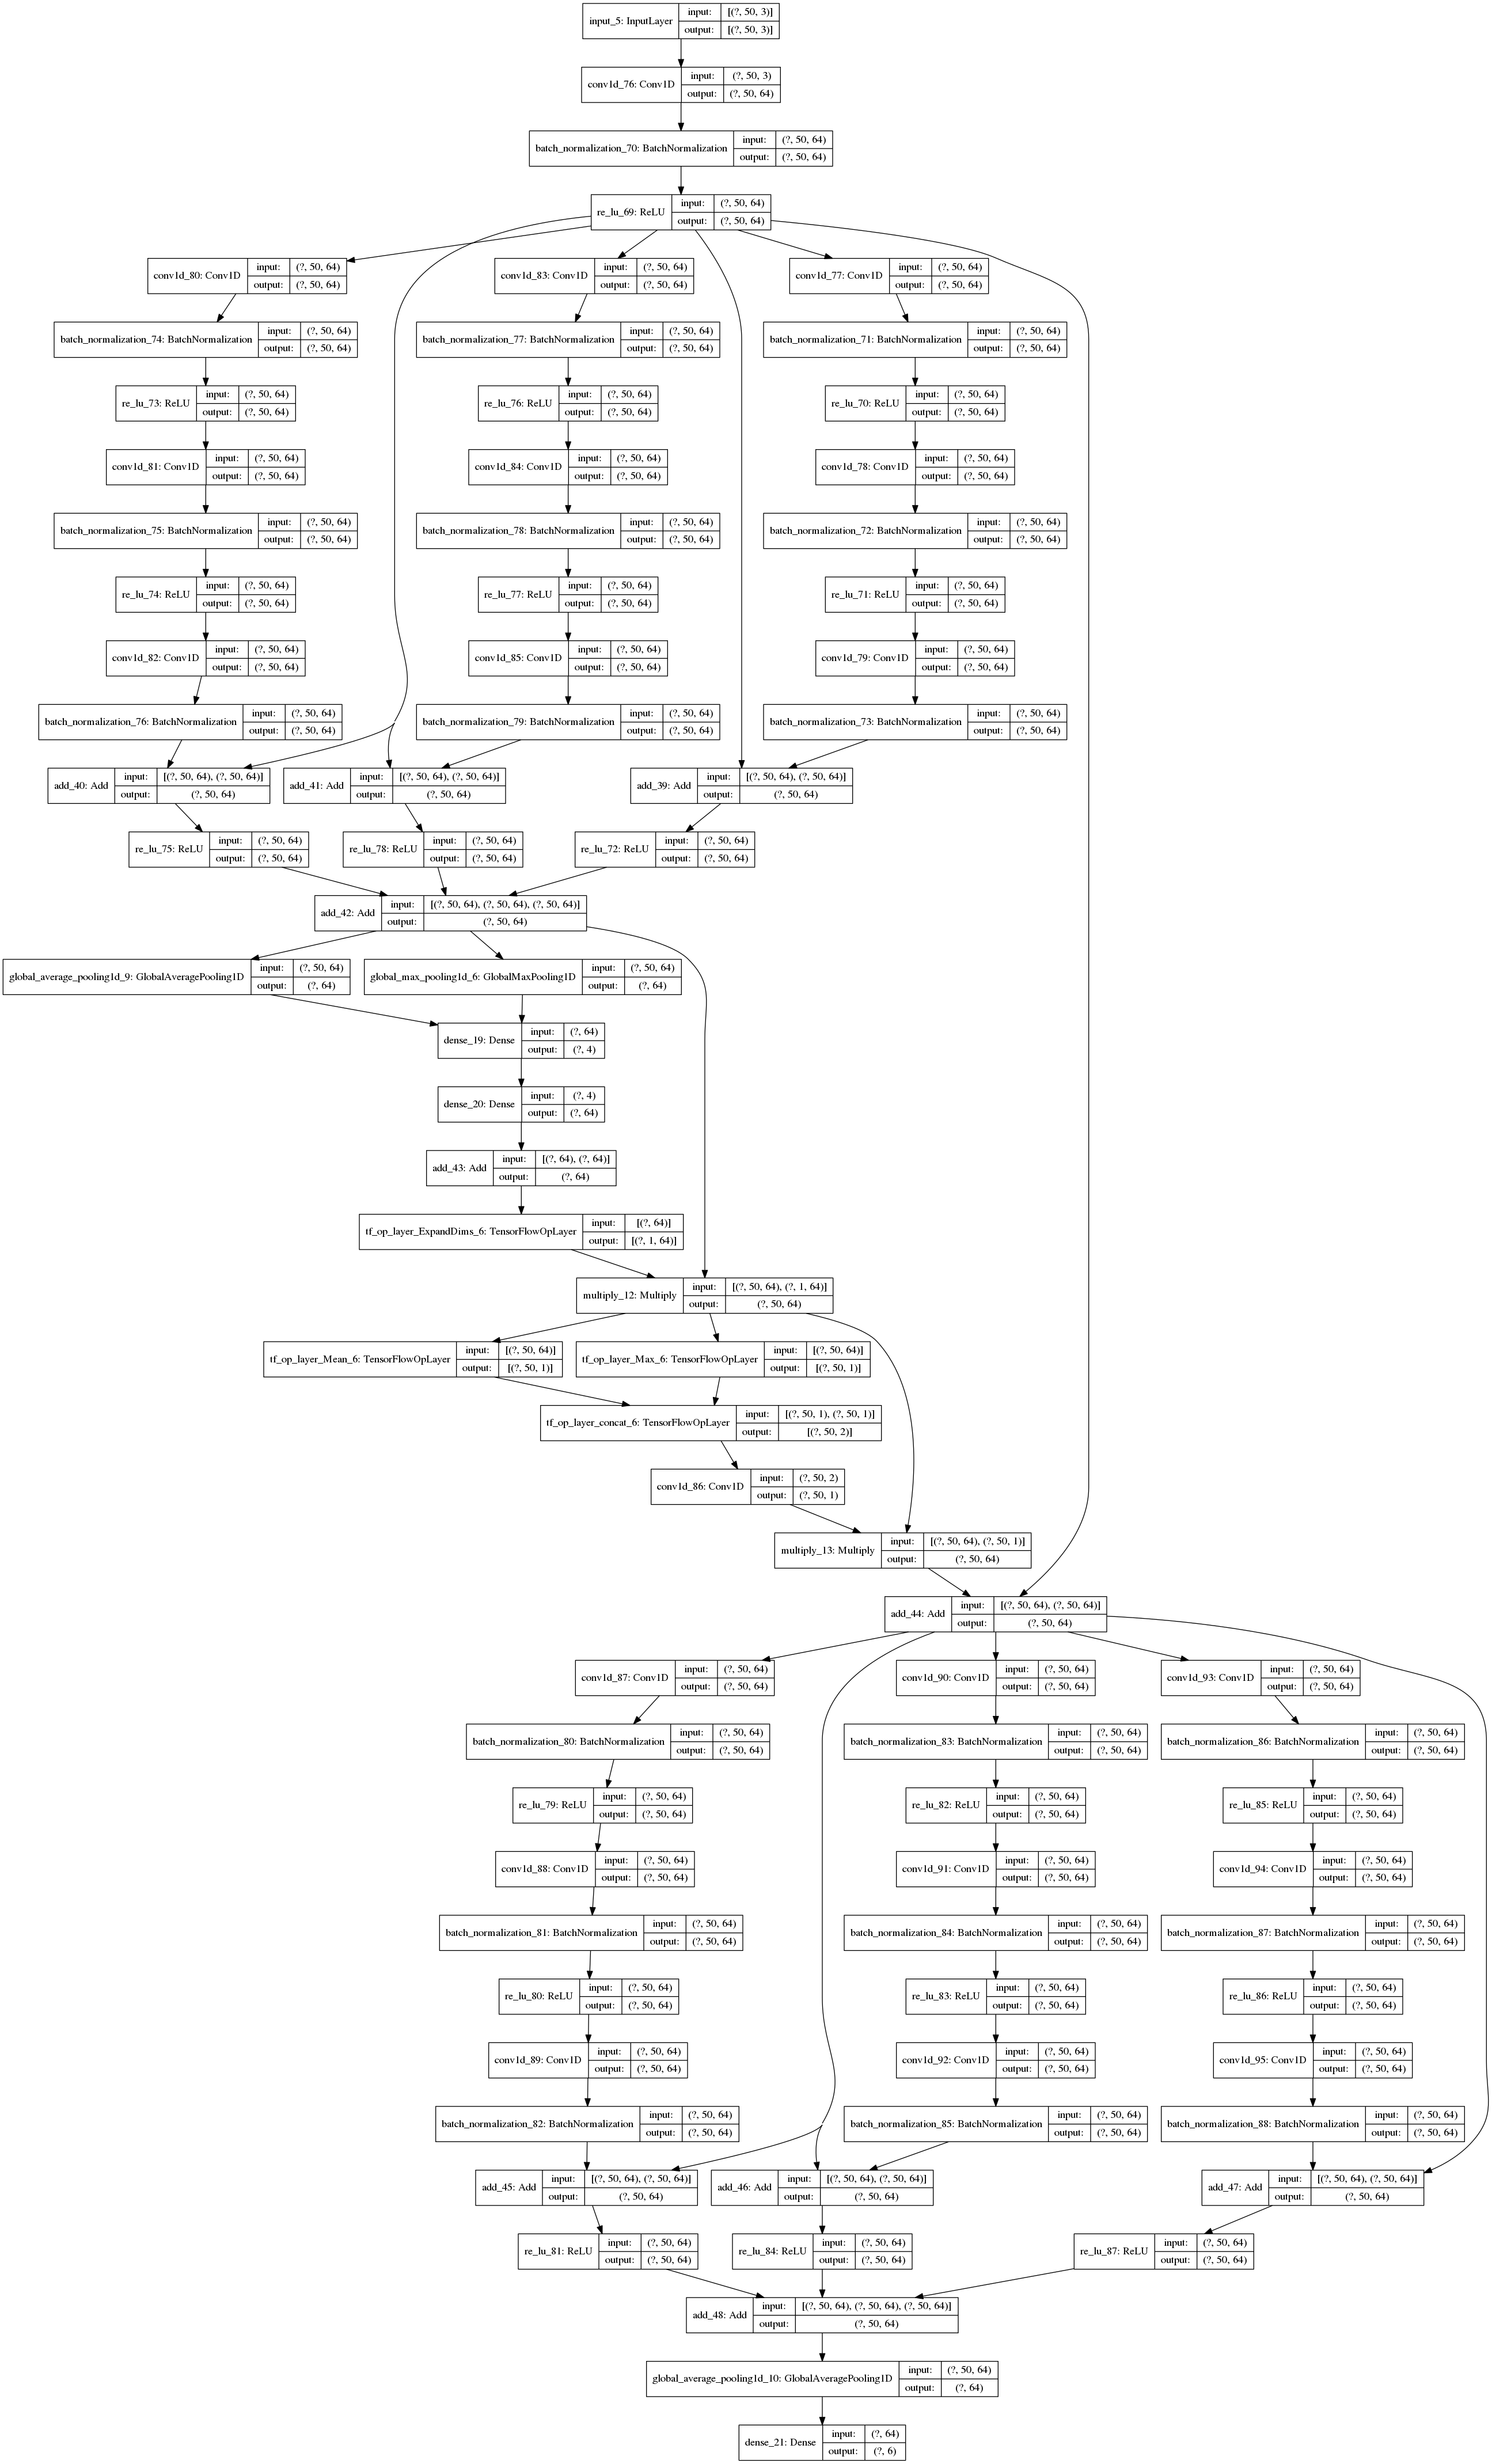

In [34]:
import tensorflow
tensorflow.keras.utils.plot_model(model4, show_shapes=True, to_file='multichannel.png')

In [35]:
batch_size=1024
history4 = model4.fit(X_train, y_train, epochs=30, validation_split=0.25,batch_size=batch_size,verbose=1)

Train on 65889 samples, validate on 21963 samples
Epoch 1/30
65889/65889 [==============================] - 11s 161us/sample - loss: 0.6663 - accuracy: 0.8083 - val_loss: 2.2855 - val_accuracy: 0.5830
Epoch 2/30
65889/65889 [==============================] - 5s 70us/sample - loss: 0.2016 - accuracy: 0.9324 - val_loss: 0.6046 - val_accuracy: 0.8195
Epoch 3/30
65889/65889 [==============================] - 5s 71us/sample - loss: 0.1442 - accuracy: 0.9520 - val_loss: 0.3404 - val_accuracy: 0.8723
Epoch 4/30
65889/65889 [==============================] - 5s 70us/sample - loss: 0.1092 - accuracy: 0.9643 - val_loss: 0.2007 - val_accuracy: 0.9262
Epoch 5/30
65889/65889 [==============================] - 5s 71us/sample - loss: 0.0896 - accuracy: 0.9705 - val_loss: 0.2677 - val_accuracy: 0.9110
Epoch 6/30
65889/65889 [==============================] - 5s 70us/sample - loss: 0.0720 - accuracy: 0.9764 - val_loss: 0.2039 - val_accuracy: 0.9302
Epoch 7/30
65889/65889 [==============================

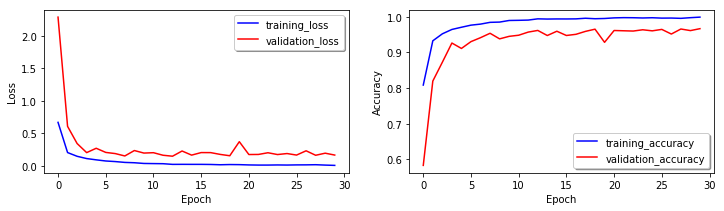

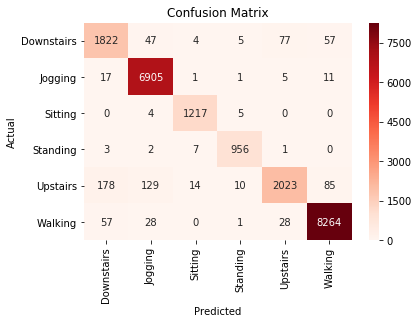

              precision    recall  f1-score   support

  Downstairs       0.88      0.91      0.89      2012
     Jogging       0.97      0.99      0.98      6940
     Sitting       0.98      0.99      0.99      1226
    Standing       0.98      0.99      0.98       969
    Upstairs       0.95      0.83      0.88      2439
     Walking       0.98      0.99      0.98      8378

    accuracy                           0.96     21964
   macro avg       0.96      0.95      0.95     21964
weighted avg       0.96      0.96      0.96     21964

ACC: 0.9646
Sensitivity: 0.9749
Specificity: 0.9975


In [36]:
display_history(history4)
plot_metrices(model4)

131784


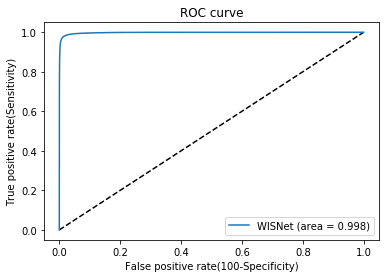

In [37]:
import sklearn.metrics
def plot_roc(model_, name):
    plt.figure()
    ax = plt.subplot()
    ax.set_title('ROC Curve')
    pred = model_.predict(X_test).ravel()
    print(pred.size)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test.ravel(), pred)
    ac = sklearn.metrics.auc(fpr, tpr)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='{} (area = {:.3f})'.format(name, ac))
    plt.xlabel('False positive rate(100-Specificity)')
    plt.ylabel('True positive rate(Sensitivity)')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show
plot_roc(model4,"WISNet")